In [2]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy

from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [3]:
N_MODULES = 5
LX = 10.0
LY = 10.0
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)



In [8]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import dok_matrix, csc_matrix
from joblib import Parallel, delayed

def angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps):
    """Performs angular consistency and bifurcation checks for a given index `i`."""
    results_ang = []
    results_bif = []
    
    vect_i = vectors[i]
    norm_i = norms[i]

    for j in range(i + 1, N):  # Only upper triangle
        vect_j = vectors[j]
        norm_j = norms[j]
        cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

        # Angular consistency
        if np.abs(cosine - 1) < eps:
            results_ang.append((i, j, 1))

        # Bifurcation consistency
        seg_i, seg_j = segments[i], segments[j]
        if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
            results_bif.append((i, j, -alpha))
        elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
            results_bif.append((i, j, -alpha))

    return results_ang, results_bif

def generate_hamiltonian_optimizedPAR(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-5  # Precision threshold

    # Perform angular and bifurcation checks in parallel
    results = []

    # Sequentially execute the angular_and_bifurcation_checks function for each index
    for i in range(N):
        ang_results, bif_results = angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps)
        results.append((ang_results, bif_results))

    # Alternatively, using a list comprehension:
    # results = [
    #     angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps)
    #     for i in range(N)
    # ]

    # Aggregate results into sparse matrices
    A_ang = dok_matrix((N, N), dtype=np.float64)
    A_bif = dok_matrix((N, N), dtype=np.float64)

    for ang_results, bif_results in results:
        for i, j, value in ang_results:
            A_ang[i, j] = value
            A_ang[j, i] = value  # Ensuring symmetry
        for i, j, value in bif_results:
            A_bif[i, j] = value
            A_bif[j, i] = value  # Ensuring symmetry

    # Convert the dictionaries of keys (DOK) matrices to compressed sparse column (CSC) format
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)
    true_solution = np.array([1 if segment.truth else 0 for segment in segments])



    return A, b, true_solution


In [9]:
def qubosolverQA(A, b, num_readss):
    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-a24be243a5f091936a200a1043c6c6219a637503'))
    response = sampler.sample(bqm, num_reads = num_readss)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    print(f"Solution: {sol_sample}")

    return sol_sample


In [6]:
from dwave.system import LeapHybridSampler
import os
#natalys 2nd token

os.environ['DWAVE_API_TOKEN'] = 'DEV-a24be243a5f091936a200a1043c6c6219a637503'
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix
from dimod import BinaryQuadraticModel

def qubosolverHr(A, b, num_readss):
   
    # Keep A sparse
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Add the linear terms from vector b
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  # Only consider off-diagonal terms (interactions)
            bqm.add_interaction(i, j, A[i, j])

    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)


    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    return sol_sample
#qubosolverHr(A, b)

In [10]:
def qubosolverSA(A, b, num_readss):
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads = num_readss)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

In [ ]:
import csv
import numpy as np  # Ensure numpy is imported
from collections import defaultdict

def collect_convergence_data_multiple_runs(
    hamiltonian_generator, qubosolvers, params, max_iterations, save_path, save_format, num_runs=5, iteration_step=5
):
    """
    Collect convergence data for multiple QUBO solvers over multiple runs using the true solution as the baseline.

    Parameters:
    - hamiltonian_generator: Function to generate the Hamiltonian matrix.
    - qubosolvers: Dictionary of solvers (name -> function).
    - params: Parameters for the Hamiltonian generator.
    - max_iterations: Maximum number of iterations to track.
    - save_path: Path to save the results file.
    - save_format: Format to save the results (e.g., 'csv').
    - num_runs: Number of runs to perform for statistical analysis.
    - iteration_step: Step size for iterations (default is 5).

    Returns:
    - all_convergence_results: Dictionary containing convergence data for each solver across all runs.
    """
    
    # Validate that max_iterations is divisible by iteration_step
    if max_iterations % iteration_step != 0:
        raise ValueError("max_iterations must be divisible by iteration_step.")
    
    # Initialize a nested dictionary to store results
    # Structure: {run_number: {solver_name: [accuracy_over_iterations]}}
    all_convergence_results = defaultdict(dict)
    
    for run in range(1, num_runs + 1):
        print(f"\nStarting run {run} of {num_runs}...")
        
        # Optionally set a unique random seed for reproducibility
        # np.random.seed(run)
        # random.seed(run)
        
        # Generate a new particle track event for each run
        event = generator.generate_event(7)
        
        # Generate the Hamiltonian for this run
        A, b, true_solution = hamiltonian_generator(event, params)
        
        # Loop through each solver
        for solver_name, solver_function in qubosolvers.items():
            print(f"  Collecting data for solver: {solver_name}...")
            accuracy_over_iterations = []  # Track accuracy over iterations
            
            # Track accuracy (fraction of correctly predicted bits) over iterations
            for iteration in range(iteration_step, max_iterations + 1, iteration_step):
                solution = solver_function(A, b, iteration)  # Run the solver for this iteration
                
                # Calculate accuracy
                accuracy = np.mean(solution == true_solution)
                accuracy_over_iterations.append(accuracy)
            
            # Store the accuracy data for this solver and run
            all_convergence_results[run][solver_name] = accuracy_over_iterations
    
    # Save the collected data
    if save_path and save_format.lower() == "csv":
        with open(save_path, 'w', newline='') as f:
            writer = csv.writer(f)
            
            # Create header: Run, Iteration, Solver1, Solver2, ...
            header = ["Run", "Iteration"] + list(qubosolvers.keys())
            writer.writerow(header)
            
            # Determine the list of iteration points
            iteration_points = list(range(iteration_step, max_iterations + 1, iteration_step))
            
            # Write data for each run and each iteration
            for run in range(1, num_runs + 1):
                for i, iteration in enumerate(iteration_points):
                    row = [
                        run,
                        iteration
                    ] + [
                        all_convergence_results[run][solver][i] for solver in qubosolvers
                    ]
                    writer.writerow(row)
        
        print(f"\nAll results saved to {save_path} in CSV format.")
    else:
        print(f"\nUnsupported save format: {save_format}. Results not saved.")
    
    return all_convergence_results

# Define solvers 
solvers = {
    #"Simulated Annealing": qubosolverSA,
    # "Hybrid Solver": qubosolverHr,  # Uncomment if needed
    "Quantum Annealing": qubosolverQA,
}

# Define parameters for the Hamiltonian generator
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,
}

# Path to save the convergence results
save_path = "convergenceQUANTUMMOREITT.csv"

# Number of runs for statistical analysis
num_runs = 5

# Define maximum number of iterations and step size
max_iterations = 250
iteration_step = 5  # New parameter for iteration steps

# Collect convergence data over multiple runs
convergence_results = collect_convergence_data_multiple_runs(
    hamiltonian_generator=generate_hamiltonian_optimizedPAR,
    qubosolvers=solvers,
    params=params,
    max_iterations=max_iterations,
    save_path=save_path,
    save_format="csv",
    num_runs=num_runs,
    iteration_step=iteration_step
)




Starting run 1 of 5...
Solution: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 

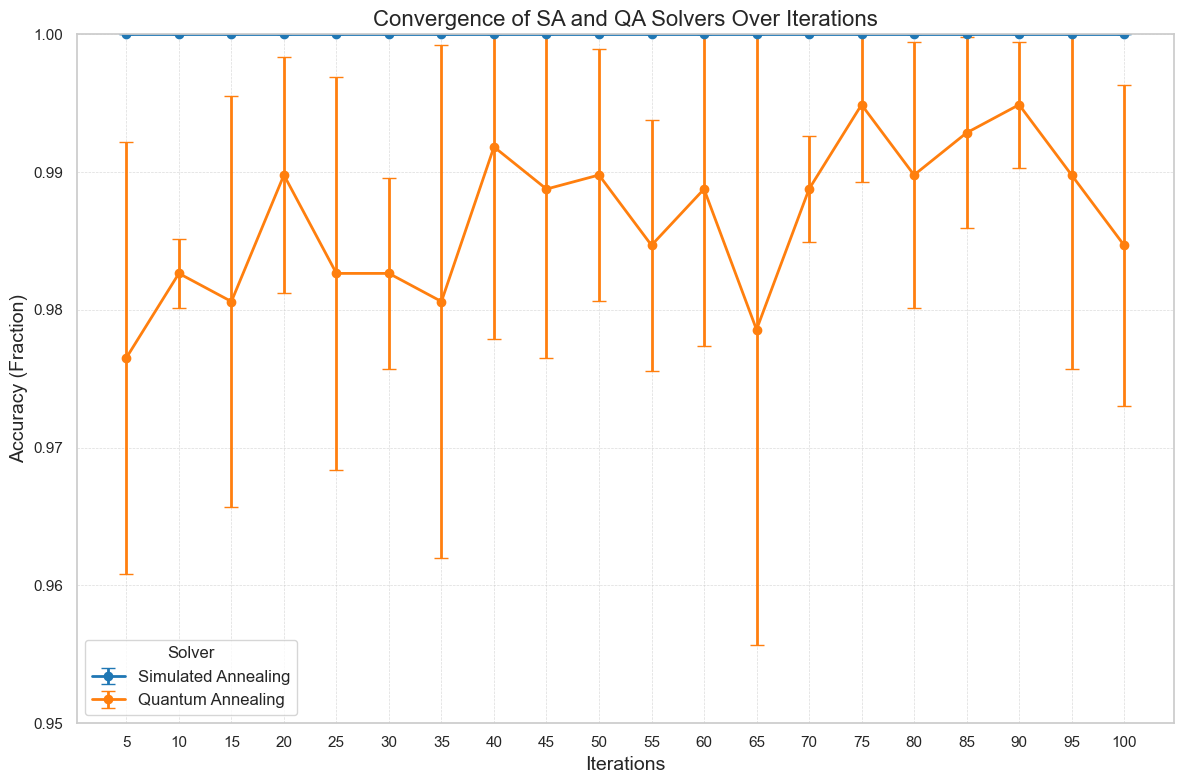


Statistics at Iteration 100:
Simulated Annealing: Mean Accuracy = 1.0000, Std Dev = 0.0000
Quantum Annealing: Mean Accuracy = 0.9847, Std Dev = 0.0116

Overall Statistics Across All Iterations:
Simulated Annealing: Overall Mean Accuracy = 1.0000, Overall Std Dev = 0.0000
Quantum Annealing: Overall Mean Accuracy = 0.9867, Overall Std Dev = 0.0052

Detailed Statistics at Each Iteration:

Solver: Simulated Annealing
 Iteration |  Mean Accuracy |  Std Dev
----------------------------------------
         5 |         1.0000 |   0.0000
        10 |         1.0000 |   0.0000
        15 |         1.0000 |   0.0000
        20 |         1.0000 |   0.0000
        25 |         1.0000 |   0.0000
        30 |         1.0000 |   0.0000
        35 |         1.0000 |   0.0000
        40 |         1.0000 |   0.0000
        45 |         1.0000 |   0.0000
        50 |         1.0000 |   0.0000
        55 |         1.0000 |   0.0000
        60 |         1.0000 |   0.0000
        65 |         1.0000 |   0.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_convergence_with_error_bars(csv_path, iteration_step=5, max_iterations=100, num_runs=5):
    """
    Plot convergence data from a CSV file with error bars and print statistics.

    Parameters:
    - csv_path: Path to the CSV file containing convergence data.
    - iteration_step: Step size for iterations (default is 5).
    - max_iterations: Maximum number of iterations (default is 100).
    - num_runs: Number of runs performed (default is 5).
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # List of solvers (excluding 'Run' and 'Iteration')
    solvers = [col for col in df.columns if col not in ['Run', 'Iteration']]
    
    # Determine iteration points
    iteration_points = list(range(iteration_step, max_iterations + 1, iteration_step))
    
    # Initialize dictionaries to store mean and standard deviation
    mean_accuracy = {solver: [] for solver in solvers}
    std_accuracy = {solver: [] for solver in solvers}
    
    # Calculate mean and std dev for each solver at each iteration
    for solver in solvers:
        for iteration in iteration_points:
            # Extract accuracy values across all runs for the current solver and iteration
            accuracies = df[df['Iteration'] == iteration][solver].values
            # Calculate mean and standard deviation
            mean = np.mean(accuracies)
            std = np.std(accuracies)
            # Append to dictionaries
            mean_accuracy[solver].append(mean)
            std_accuracy[solver].append(std)
    
    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("tab10", n_colors=len(solvers))
    
    for idx, solver in enumerate(solvers):
        plt.errorbar(
            iteration_points,
            mean_accuracy[solver],
            yerr=std_accuracy[solver],
            label=solver,
            color=colors[idx],
            marker='o',
            capsize=5,
            linestyle='-',
            linewidth=2
        )
    
    # Customize the plot
    plt.title("Convergence of SA and QA Solvers Over Iterations", fontsize=16)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Accuracy (Fraction)", fontsize=14)
    plt.legend(title='Solver', fontsize=12)
    plt.xticks(iteration_points)
    plt.ylim(0.95, 1)  # Assuming accuracy ranges between 0 and 1
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    
    plt.tight_layout()
    plt.show()
    
    # Printing Statistics
    # a. Final Iteration Statistics
    final_iteration = max_iterations
    print(f"\nStatistics at Iteration {final_iteration}:")
    for solver in solvers:
        mean_final = mean_accuracy[solver][-1]
        std_final = std_accuracy[solver][-1]
        print(f"{solver}: Mean Accuracy = {mean_final:.4f}, Std Dev = {std_final:.4f}")
    
    # b. Overall Statistics Across All Iterations
    print("\nOverall Statistics Across All Iterations:")
    for solver in solvers:
        all_accuracies = mean_accuracy[solver]
        overall_mean = np.mean(all_accuracies)
        overall_std = np.std(all_accuracies)
        print(f"{solver}: Overall Mean Accuracy = {overall_mean:.4f}, Overall Std Dev = {overall_std:.4f}")
    
    # c. Detailed Statistics at Each Iteration
    print("\nDetailed Statistics at Each Iteration:")
    for solver in solvers:
        print(f"\nSolver: {solver}")
        print(f"{'Iteration':>10} | {'Mean Accuracy':>14} | {'Std Dev':>8}")
        print("-" * 40)
        for i, iteration in enumerate(iteration_points):
            mean = mean_accuracy[solver][i]
            std = std_accuracy[solver][i]
            print(f"{iteration:>10} | {mean:>14.4f} | {std:>8.4f}")

# Example Usage
if __name__ == "__main__":
    # Define the path to the CSV file
    csv_path = "convergence_results_multiple_runs.csv"
    
    # Call the plotting function
    plot_convergence_with_error_bars(
        csv_path=csv_path,
        iteration_step=5,
        max_iterations=100,
        num_runs=5
    )


In [9]:
import csv 
def collect_convergence_data(hamiltonian_generator, qubosolvers, event, params, max_iterations, save_path, save_format):
    """
    Collect convergence data for multiple QUBO solvers using true solution as the baseline.

    Parameters:
    - hamiltonian_generator: Function to generate the Hamiltonian matrix.
    - qubosolvers: Dictionary of solvers (name -> function).
    - event: The event data used by the Hamiltonian generator.
    - params: Parameters for the Hamiltonian generator.
    - max_iterations: Maximum number of iterations to track.

    Returns:
    - convergence_results: Dictionary containing convergence data for each solver.
    """

    # Generate the Hamiltonian
    A, b, true_solution = hamiltonian_generator(event, params)

    # Initialize results dictionary
    convergence_results = {}

    # Loop through solvers
    for solver_name, solver_function in qubosolvers.items():
        print(f"Collecting convergence data for {solver_name}...")
        accuracy_over_iterations = []  # Track accuracy over iterations

        # Track accuracy (Hamming distance from true_solution) over iterations
        for iteration in range(1, max_iterations + 1):
            solution = solver_function(A, b, iteration)  # Run the solver for this iteration

            # Calculate accuracy as fraction of correctly predicted bits
            accuracy = np.mean(solution == true_solution)
            accuracy_over_iterations.append(accuracy)

        # Store results
        convergence_results[solver_name] = accuracy_over_iterations
    if save_path:
        if save_format == "csv":
            with open(save_path, 'w', newline='') as f:
                writer = csv.writer(f)
                # Write header
                writer.writerow(["Iteration"] + list(convergence_results.keys()))
                # Write rows
                for i in range(max_iterations):
                    row = [i + 1] + [convergence_results[solver][i] for solver in convergence_results]
                    writer.writerow(row)
            print(f"Results saved to {save_path} in CSV format.")
        else:
            print(f"Unsupported save format: {save_format}. Results not saved.")
        return convergence_results


In [ ]:
# Define solvers
solvers = {
    "Simulated Annealing": qubosolverSA,
    #"Hybrid Solver": qubosolverHr,
    "Quantum Annealing": qubosolverQA,
}

# Define parameters for the Hamiltonian generator
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,
}

# Generate a particle track event
event = generator.generate_event(7)

save_path = "convergence_results.csv"
# Collect convergence data
convergence_results = collect_convergence_data(
    hamiltonian_generator=generate_hamiltonian_optimizedPAR,
    qubosolvers=solvers,
    event=event,
    params=params,
    max_iterations = 100,
    save_path=save_path,
    save_format="csv"
)




Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 

NameError: name 'max_iterations' is not defined

In [ ]:
def plot_convergence(run_results, max_iterations, solver_names):
    """
    Plot the convergence metrics with error bars.

    Parameters:
    - run_results: List of convergence_results from each run.
    - max_iterations: Maximum number of iterations.
    - solver_names: Iterable of solver names.
    """
    # Convert run_results (list of dicts) to a dict of solver_name -> list of lists
    # Each inner list corresponds to a run's accuracy over iterations
    solver_data = {solver: [] for solver in solver_names}
    for run in run_results:
        for solver in solver_names:
            solver_data[solver].append(run[solver])

    # Compute mean and std for each solver at each iteration
    mean_convergence = {solver: np.mean(solver_data[solver], axis=0) for solver in solver_names}
    std_convergence = {solver: np.std(solver_data[solver], axis=0) for solver in solver_names}

    iterations = np.arange(1, max_iterations + 1)

    plt.figure(figsize=(10, 6))

    for solver in solver_names:
        plt.errorbar(
            iterations,
            mean_convergence[solver],
            yerr=std_convergence[solver],
            fmt='-o',
            capsize=5,
            label=solver
        )

    plt.title('Convergence Testing with Error Bars')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (Fraction of Correct Bits)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



run_results = []  # To store convergence_results from each run

for run in range(1, num_runs + 1):
    print(f"\n=== Run {run}/{num_runs} ===")
    # Deep copy the original event to avoid modifying it
    event = copy.deepcopy(original_event)

    # Add tracking noise
    noisy_event = add_tracking_noise(event, sigma_position)

    # Define save_path for this run
    save_path = os.path.join(save_dir, f"convergence_run{run}.csv")

    # Collect convergence data
    convergence = collect_convergence_data(
        hamiltonian_generator=hamiltonian_generator,
        qubosolvers=qubosolvers,
        event=noisy_event,
        params=params,
        max_iterations=max_iterations,
        save_path=save_path,
        save_format="csv"
    )

    # Append to run_results
    run_results.append(convergence)

# Save all run results as a NumPy file for easy loading later
np_save_path = os.path.join(save_dir, "all_runs_convergence.npy")
np.save(np_save_path, run_results)
print(f"\nAll run results saved to {np_save_path}")

# Optionally, save all run results in a single CSV with multi-level columns
# This step is optional and can be skipped if not needed
all_runs_df = pd.DataFrame()
for run_idx, convergence in enumerate(run_results, start=1):
    run_df = pd.DataFrame(convergence)
    run_df['Iteration'] = range(1, max_iterations + 1)
    run_df.set_index('Iteration', inplace=True)
    # Prefix solver names with run number
    run_df = run_df.add_prefix(f'Run{run_idx}_')
    all_runs_df = pd.concat([all_runs_df, run_df], axis=1)
combined_csv_path = os.path.join(save_dir, "all_runs_convergence_combined.csv")
all_runs_df.to_csv(combined_csv_path)
print(f"All run results combined and saved to {combined_csv_path}")

# Plot convergence with error bars
plot_convergence(run_results, max_iterations, qubosolvers.keys())


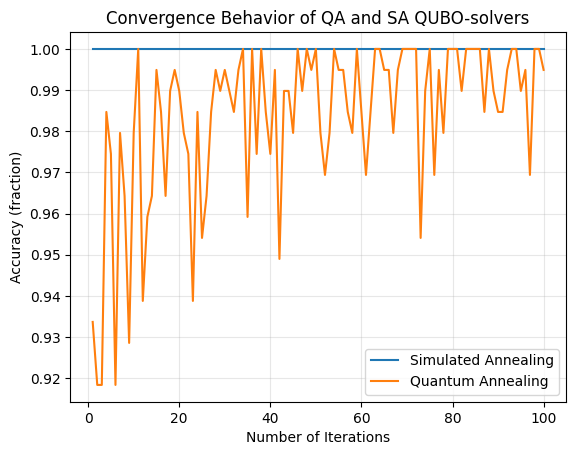

In [5]:
import matplotlib.pyplot as plt
import csv

file_path = "convergence_results.csv"

# Initialize storage for results
convergence_results = {}
iterations = []

# Read the CSV and store results
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Read header
    solvers = header[1:]  # Solver names (skip 'Iteration')
    for solver in solvers:
        convergence_results[solver] = []

    # Read each row of the CSV
    for row in reader:
        iterations.append(int(row[0]))  # Store iteration numbers
        for i, solver in enumerate(solvers):
            convergence_results[solver].append(float(row[i + 1]))

# Plot convergence behavior
for solver_name, accuracies in convergence_results.items():
    plt.plot(iterations, accuracies, label=solver_name)

plt.title("Convergence Behavior of QA and SA QUBO-solvers")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy (fraction)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [27]:
def add_tracking_noise(event, sigma_position):
    """
    Add noise to an event for particle track reconstruction.

    Parameters:
    - event: The event data containing hits and modules.
    - sigma_position: Standard deviation of noise in hit positions.

    Returns:
    - event: Noisy event.
    """
    # Add noise to hit positions
    for module in event.modules:
        for hit in module.hits:
            hit.x += np.random.normal(0, sigma_position)
            hit.y += np.random.normal(0, sigma_position)

    return event

In [29]:
import json
import numpy as np
import time
#noice, gaussian stuff added to the hit positions
import time
import json
import numpy as np

def compare_solvers_over_noise(
    hamiltonian_generator, 
    qubosolvers, 
    N_PARTICLES, 
    noise_levels, 
    repetitions, 
    save_path
):
    """
    Compare multiple QUBO solvers over a range of noise levels with multiple repetitions.

    Parameters:
    - hamiltonian_generator: Function to generate the Hamiltonian matrix.
    - qubosolvers: Dictionary of solvers (name -> function).
    - N_PARTICLES: Number of particles for event generation.
    - noise_levels: List of noise levels to simulate.
    - repetitions: Number of repetitions per noise level.
    - save_path: Path to save the results in JSON format.

    Returns:
    - results: Dictionary containing the comparison data.
    """
    # Set Hamiltonian generator parameters
    params = {
        'alpha': 1.0,
        'beta': 1.0,
        'lambda': 100.0,
    }

    # Initialize results dictionary
    results = {
        "noise_levels": noise_levels,
        "repetitions": repetitions,
        "solvers": {}
    }

    # Loop through solvers
    for solver_name, solver_function in qubosolvers.items():
        # Initialize nested dictionaries for each solver
        results["solvers"][solver_name] = {
            "accuracy": {noise: [] for noise in noise_levels},
            "runtime": {noise: [] for noise in noise_levels}
        }

        for noise in noise_levels:
            for rep in range(repetitions):
                try:
                    # Generate event and add noise
                    event = generator.generate_event(N_PARTICLES)
                    noisy_event = add_tracking_noise(
                        event, 
                        sigma_position=noise
                    )

                    # Generate Hamiltonian from noisy event
                    A, b, true_solution = hamiltonian_generator(noisy_event, params)

                    # Time the solver
                    start_time = time.time()
                    solution = solver_function(A, b, 100)
                    runtime = time.time() - start_time

                    # Calculate accuracy
                    accuracy = float(np.mean(solution == true_solution))

                    # Save results
                    results["solvers"][solver_name]["accuracy"][noise].append(accuracy)
                    results["solvers"][solver_name]["runtime"][noise].append(runtime)
                except Exception as e:
                    print(f'Error for solver "{solver_name}" at noise level {noise}, repetition {rep+1}: {e}')
                    # Optionally, you can append None or some default value
                    results["solvers"][solver_name]["accuracy"][noise].append(None)
                    results["solvers"][solver_name]["runtime"][noise].append(None)

    # Save results to file
    with open(save_path, 'w') as f:
        json.dump(results, f, indent=4)

    return results

# Example usage
if __name__ == "__main__":
    solvers = {
        "Simulated Annealing": qubosolverSA,
        "Hybrid Solver": qubosolverHr,
        "Quantum Annealing": qubosolverQA,
    }
    save_path = 'noise7particles5repetitions.json'
    
    # Define parameters
    noise_levels = [0.001, 0.002, 0.003, 0.004, 0.005, 
                   0.006, 0.007, 0.008, 0.009, 0.01]
    repetitions = 5

    results = compare_solvers_over_noise(
        hamiltonian_generator=generate_hamiltonian_optimizedPAR,
        qubosolvers=solvers,
        N_PARTICLES=7,
        noise_levels=noise_levels,
        repetitions=repetitions,
        save_path=save_path
    )

    print("Comparison completed and results saved to", save_path)


Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 

In [30]:
pip install prettytable


  Obtaining dependency information for prettytable from https://files.pythonhosted.org/packages/73/19/4bb9530512432774fdd7cb7c020851d4decbb811d95f86fd4f6a870a6d3e/prettytable-3.12.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


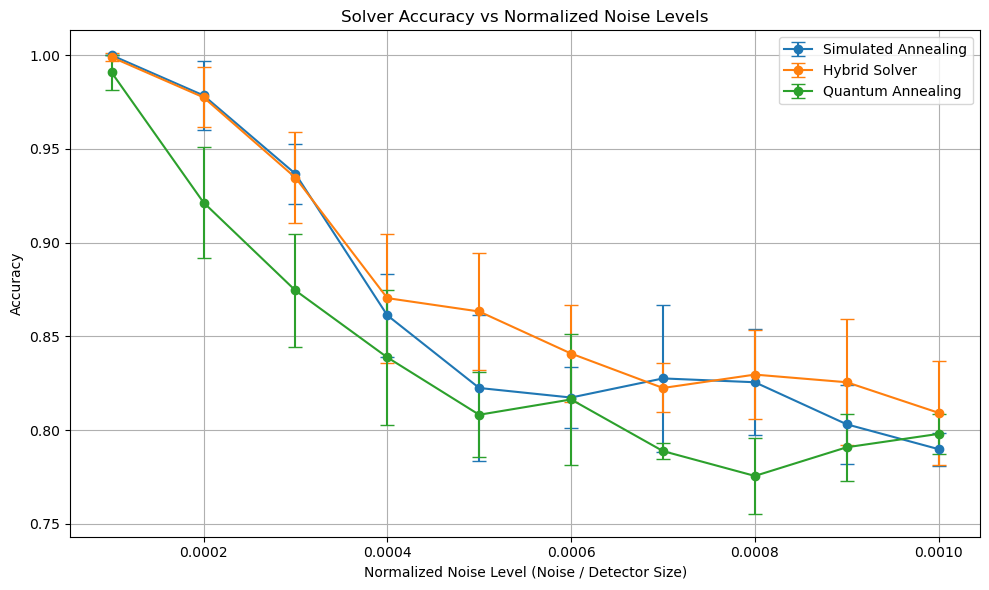

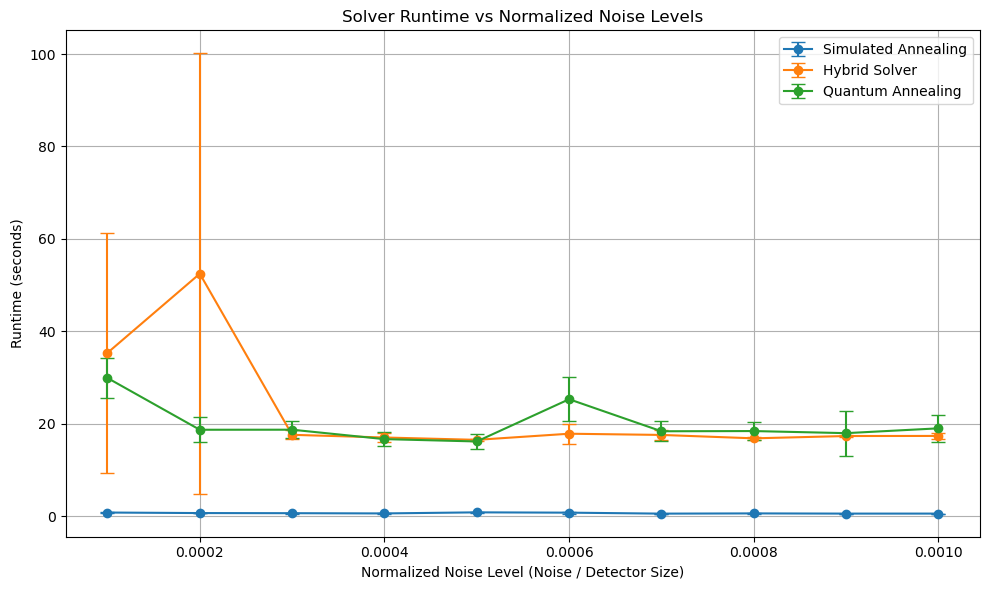

+---------------------+-------------+---------------+--------------+------------------+-----------------+
|        Solver       | Noise Level | Accuracy Mean | Accuracy Std | Runtime Mean (s) | Runtime Std (s) |
+---------------------+-------------+---------------+--------------+------------------+-----------------+
| Simulated Annealing |    0.001    |     1.0000    |    0.0000    |      0.8189      |      0.1104     |
| Simulated Annealing |    0.002    |     0.9786    |    0.0184    |      0.7048      |      0.0518     |
| Simulated Annealing |    0.003    |     0.9367    |    0.0160    |      0.6766      |      0.0834     |
| Simulated Annealing |    0.004    |     0.8612    |    0.0220    |      0.6264      |      0.0180     |
| Simulated Annealing |    0.005    |     0.8224    |    0.0388    |      0.8594      |      0.0728     |
| Simulated Annealing |    0.006    |     0.8173    |    0.0163    |      0.7929      |      0.2025     |
| Simulated Annealing |    0.007    |     0.82

In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable  # For formatted console output

def load_results(json_path):
    """
    Load the solver comparison results from a JSON file.

    Parameters:
    - json_path: Path to the JSON file.

    Returns:
    - results: Dictionary containing the comparison data.
    """
    with open(json_path, 'r') as f:
        results = json.load(f)
    return results

def compute_statistics(results):
    """
    Compute mean and standard deviation of accuracy and runtime for each solver and noise level.

    Parameters:
    - results: Dictionary containing the comparison data.

    Returns:
    - stats: Nested dictionary with statistics.
    """
    noise_levels = results["noise_levels"]
    solvers = results["solvers"]

    stats = {}
    for solver_name, solver_data in solvers.items():
        stats[solver_name] = {
            "accuracy_mean": [],
            "accuracy_std": [],
            "runtime_mean": [],
            "runtime_std": []
        }
        for noise in noise_levels:
            noise_str = str(noise)  # JSON keys are strings
            accuracies = solver_data["accuracy"][noise_str]
            runtimes = solver_data["runtime"][noise_str]

            # Filter out None values if any
            accuracies = [a for a in accuracies if a is not None]
            runtimes = [r for r in runtimes if r is not None]

            # Compute statistics
            acc_mean = np.mean(accuracies) if accuracies else float('nan')
            acc_std = np.std(accuracies) if accuracies else float('nan')
            run_mean = np.mean(runtimes) if runtimes else float('nan')
            run_std = np.std(runtimes) if runtimes else float('nan')

            stats[solver_name]["accuracy_mean"].append(acc_mean)
            stats[solver_name]["accuracy_std"].append(acc_std)
            stats[solver_name]["runtime_mean"].append(run_mean)
            stats[solver_name]["runtime_std"].append(run_std)
    return stats

def plot_accuracy(noise_levels, stats, detector_size, save_path=None):
    """
    Plot solvers' accuracy vs normalized noise levels with error bars.

    Parameters:
    - noise_levels: List of noise levels.
    - stats: Nested dictionary with statistics.
    - detector_size: Size of the detector plane.
    - save_path: Optional path to save the plot.
    """
    # Normalize noise levels
    noise_levels_normalized = [noise / detector_size for noise in noise_levels]

    plt.figure(figsize=(10, 6))
    for solver_name, solver_stats in stats.items():
        plt.errorbar(
            noise_levels_normalized,
            solver_stats["accuracy_mean"],
            yerr=solver_stats["accuracy_std"],
            label=solver_name,
            marker='o',
            capsize=5
        )
    
    plt.title('Solver Accuracy vs Normalized Noise Levels')
    plt.xlabel('Normalized Noise Level (Noise / Detector Size)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionally, add a reference line or annotation for detector size
    # For example, if you want to indicate the detector size on the plot, you can add:
    # plt.axvline(x=1, color='grey', linestyle='--', label='Detector Size')
    # But since we normalized noise by detector size, this might not be necessary.

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_runtime(noise_levels, stats, detector_size, save_path=None):
    """
    Plot solvers' runtime vs normalized noise levels with error bars.

    Parameters:
    - noise_levels: List of noise levels.
    - stats: Nested dictionary with statistics.
    - detector_size: Size of the detector plane.
    - save_path: Optional path to save the plot.
    """
    # Normalize noise levels
    noise_levels_normalized = [noise / detector_size for noise in noise_levels]

    plt.figure(figsize=(10, 6))
    for solver_name, solver_stats in stats.items():
        plt.errorbar(
            noise_levels_normalized,
            solver_stats["runtime_mean"],
            yerr=solver_stats["runtime_std"],
            label=solver_name,
            marker='o',
            capsize=5
        )
    
    plt.title('Solver Runtime vs Normalized Noise Levels')
    plt.xlabel('Normalized Noise Level (Noise / Detector Size)')
    plt.ylabel('Runtime (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

def print_statistics(noise_levels, stats):
    """
    Print a table of statistics for each solver and noise level.

    Parameters:
    - noise_levels: List of noise levels.
    - stats: Nested dictionary with statistics.
    """
    table = PrettyTable()
    table.field_names = [
        "Solver", "Noise Level", 
        "Accuracy Mean", "Accuracy Std", 
        "Runtime Mean (s)", "Runtime Std (s)"
    ]
    
    for solver_name, solver_stats in stats.items():
        for i, noise in enumerate(noise_levels):
            acc_mean = solver_stats["accuracy_mean"][i]
            acc_std = solver_stats["accuracy_std"][i]
            run_mean = solver_stats["runtime_mean"][i]
            run_std = solver_stats["runtime_std"][i]
            
            table.add_row([
                solver_name,
                noise,
                f"{acc_mean:.4f}",
                f"{acc_std:.4f}",
                f"{run_mean:.4f}",
                f"{run_std:.4f}"
            ])
    
    print(table)

def main():
    # Path to the JSON file
    json_path = 'noise7particles5repetitions.json'
    
    # Define detector plane size
    detector_size = 10.0  # units
    
    # Load results
    results = load_results(json_path)
    
    # Extract noise levels
    noise_levels = results["noise_levels"]
    
    # Compute statistics
    stats = compute_statistics(results)
    
    # Plot Accuracy vs Normalized Noise Levels
    plot_accuracy(
        noise_levels=noise_levels, 
        stats=stats, 
        detector_size=detector_size,
        save_path='accuracy_vs_normalized_noise.png'  # Optional: Save the plot as a PNG file
    )
    
    # Plot Runtime vs Normalized Noise Levels
    plot_runtime(
        noise_levels=noise_levels, 
        stats=stats, 
        detector_size=detector_size,
        save_path='runtime_vs_normalized_noise.png'  # Optional: Save the plot as a PNG file
    )
    
    # Print Statistics
    print_statistics(noise_levels, stats)

if __name__ == "__main__":
    main()




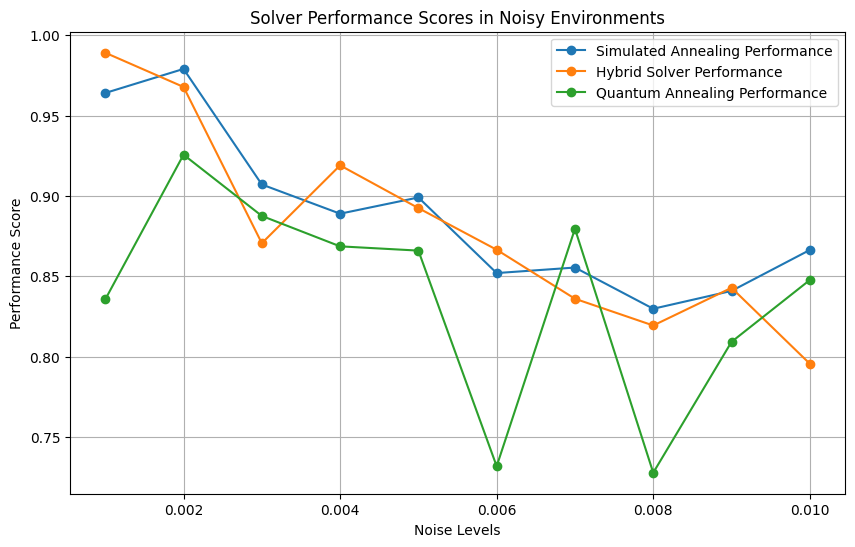

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
noise_levels = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
sa_accuracy = np.array([1.0, 0.9795918367346939, 0.8673469387755102, 0.8418367346938775,
                        0.8979591836734694, 0.8673469387755102, 0.7959183673469388,
                        0.7704081632653061, 0.7959183673469388, 0.8112244897959183])
sa_runtime = np.array([0.5221836566925049, 0.470078706741333, 0.45967817306518555, 0.46018099784851074,
                       0.5098297595977783, 0.5632050037384033, 0.46230316162109375, 0.4747166633605957,
                       0.48601317405700684, 0.461961030960083])
hs_accuracy = np.array([1.0, 0.9540816326530612, 0.8979591836734694, 0.9030612244897959,
                        0.8673469387755102, 0.8418367346938775, 0.8010204081632653,
                        0.8316326530612245, 0.7806122448979592, 0.8214285714285714])
hs_runtime = np.array([10.167665958404541, 9.800376653671265, 12.148946762084961, 10.247549295425415,
                       10.305114269256592, 10.60526180267334, 10.679672956466675, 12.39390516281128,
                       9.919597864151001, 13.329343795776367])
qa_accuracy = np.array([0.9846938775510204, 0.9795918367346939, 0.8877551020408163, 0.9030612244897959,
                        0.8316326530612245, 0.8112244897959183, 0.8163265306122449,
                        0.7704081632653061, 0.7806122448979592, 0.7704081632653061])
qa_runtime = np.array([14.854636669158936, 8.782946586608887, 7.852715492248535, 8.88581657409668,
                       7.329554319381714, 12.988264560699463, 6.7305238246917725, 11.186258554458618,
                       7.921636343002319, 6.7135748863220215])

# Normalize metrics
accuracy_normalized = {
    "Simulated Annealing": sa_accuracy / np.max(sa_accuracy),
    "Hybrid Solver": hs_accuracy / np.max(hs_accuracy),
    "Quantum Annealing": qa_accuracy / np.max(qa_accuracy),
}

runtime_normalized = {
    "Simulated Annealing": np.min(sa_runtime) / sa_runtime,  # Inverse to make lower runtime better
    "Hybrid Solver": np.min(hs_runtime) / hs_runtime,
    "Quantum Annealing": np.min(qa_runtime) / qa_runtime,
}

# Performance score (weighted average)
alpha, beta = 0.7, 0.3  # Weights: prioritize accuracy over runtime
performance_scores = {
    solver: alpha * accuracy + beta * runtime
    for solver, (accuracy, runtime) in zip(
        accuracy_normalized.keys(), zip(accuracy_normalized.values(), runtime_normalized.values())
    )
}

# Plot Performance Scores
plt.figure(figsize=(10, 6))
for solver, scores in performance_scores.items():
    plt.plot(noise_levels, scores, label=f"{solver} Performance", marker="o")

plt.xlabel("Noise Levels")
plt.ylabel("Performance Score")
plt.title("Solver Performance Scores in Noisy Environments")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.spatial.distance import hamming
from scipy.sparse import csc_matrix

import numpy as np

def calculate_accuracy_metrics(true_solution, solver_solution):
    true_solution = np.array(true_solution)
    solver_solution = np.array(solver_solution)
    
    #total `1`s in true_solution
    N_gen_hit = np.sum(true_solution == 1)
    
    #number of `1`s in solver_solution that match `1`s in true_solution)
    N_correct_hit = np.sum((true_solution == 1) & (solver_solution == 1))
    
    # Hit-efficiency (e_eff): Fraction of true hits that are correctly identified in solver_solution
    e_eff = N_correct_hit / N_gen_hit if N_gen_hit > 0 else 0

    N_all_track = np.sum(solver_solution == 1)
    N_fake_track = N_all_track - N_correct_hit
    
    #fraction of found tracks that are not associated with a true hit
    f_fake = N_fake_track / N_all_track if N_all_track > 0 else 0
    
    #Fraction of hits in solver_solution that are correctly assigned
    e_pure = N_correct_hit / N_all_track if N_all_track > 0 else 0
    
    return e_eff, f_fake, e_pure

import pickle
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix

def save_progress(pickle_file, data):
    """Save data to a pickle file, overwriting the file each time."""
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

def load_progress(pickle_file):
    """Load data from a pickle file, or return an empty list if the file doesn't exist."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

def compare_qubo_solvers(N_PARTICLES_LIST, params, pickle_file='progress.pkl'):
    results = load_progress(pickle_file)  # Load previously saved progress

    # Initialize flags to track which solvers should continue
    qubosolverSA_active = True
    qubosolverHr_active = True
    qubosolverQA_active = False

    for N_PARTICLES in N_PARTICLES_LIST:
        try:
            # Check if N_PARTICLES has already been processed
            if any(res["N_PARTICLES"] == N_PARTICLES for res in results):
                print(f"N_PARTICLES={N_PARTICLES} already processed. Skipping.")
                continue

            # Generate event and matrix
            event = generator.generate_event(N_PARTICLES)
            A, b, true_solution = generate_hamiltonian_optimizedPAR(event, params)
            A = csc_matrix(A)
            b = np.array(b, dtype=np.int8)

            # Save true_solution for this N_PARTICLES
            results.append({"N_PARTICLES": N_PARTICLES, "Solver": "TrueSolution", 
                            "Solution": true_solution.tolist()})
            save_progress(pickle_file, results)

            # Only attempt qubosolverSA if it hasn't encountered an error previously
            if qubosolverSA_active:
                try:
                    sol1 = np.array(qubosolverSA(A, b), dtype=np.int8)
                    accuracy_1 = calculate_accuracy_metrics(true_solution, sol1)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverSA", 
                                    "Hit Efficiency": accuracy_1[0],
                                    "Fake Rates": accuracy_1[1], 
                                    "Hit Purity": accuracy_1[2],
                                    "Solution": sol1.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverSA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverSA_active = False  # Deactivate further testing of qubosolverSA

            # Only attempt qubosolverHr if it hasn't encountered an error previously
            if qubosolverHr_active:
                try:
                    sol2 = np.array(qubosolverHr(A, b), dtype=np.int8)
                    accuracy_2 = calculate_accuracy_metrics(true_solution, sol2)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverHr", 
                                    "Hit Efficiency": accuracy_2[0],
                                    "Fake Rates": accuracy_2[1], 
                                    "Hit Purity": accuracy_2[2],
                                    "Solution": sol2.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverHr for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverHr_active = False  # Deactivate further testing of qubosolverHr

            # Only attempt qubosolverQA if it hasn't encountered an error previously
            if qubosolverQA_active:
                try:
                    sol3 = np.array(qubosolverQA(A, b), dtype=np.int8)
                    accuracy_3 = calculate_accuracy_metrics(true_solution, sol3)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverQA", 
                                    "Hit Efficiency": accuracy_3[0],
                                    "Fake Rates": accuracy_3[1], 
                                    "Hit Purity": accuracy_3[2],
                                    "Solution": sol3.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverQA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverQA_active = False  # Deactivate further testing of qubosolverQA

        except MemoryError as mem_err:
            print(f"MemoryError encountered for N_PARTICLES={N_PARTICLES}: {mem_err}")
            continue

        except Exception as e:
            print(f"An error occurred while preparing for N_PARTICLES={N_PARTICLES}: {e}")
            continue

    results_df = pd.DataFrame(results)
    results_df.to_csv("qubo_solver_results.csv", index=False)
    return results_df

# Parameters and Particle List
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}
N_PARTICLES_LIST = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Run the comparison function and save the results
results_df = compare_qubo_solvers(N_PARTICLES_LIST, params)
results_df.to_csv("qubossolutioncomparisment.csv", index=False)



Solution:[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 

In [ ]:
#data for 80 particles 5 layers, QA< SA AND HYBRID

import pandas as pd

# Load the previously saved CSV file
results_df = pd.read_csv("qubos80particleSOLUTIONSTESTING.csv")

latex_table = results_df.to_latex(index=False, float_format="%.2f", 
                                    caption="Comparison of QUBO Solvers on Particle Tracks",
                                    label="tab:qubo_solver_results")

# Save LaTeX table to file
with open("qubo_solver_results.tex", "w") as file:
    file.write(latex_table)



 N_PARTICLES       Solver  Percentage_Similarity  Hamming_Distance  Simple_Matching_Coefficient
           2 qubosolverSA              100.00000                 0                      1.00000
           2 qubosolverHr              100.00000                 0                      1.00000
           2 qubosolverQA              100.00000                 0                      1.00000
           4 qubosolverSA              100.00000                 0                      1.00000
           4 qubosolverHr              100.00000                 0                      1.00000
           4 qubosolverQA              100.00000                 0                      1.00000
           6 qubosolverSA              100.00000                 0                      1.00000
           6 qubosolverHr              100.00000                 0                      1.00000
           6 qubosolverQA               98.61110                 1                      0.98610
           8 qubosolverSA              1

In [3]:
import pandas as pd
import numpy as np

# Define the data with inconsistent lengths
data = {
    "N_PARTICLES": [2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18, 20, 20],
    "Solver": ["qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr"],
    "Hit Efficiency": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6875, 1.0, 1.0, 0.475, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    "Fake Rate": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2143, 0.0, 0.0, 0.3667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "Hit Purity": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7857, 1.0, 1.0, 0.6333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

# Find the maximum length of the data arrays
max_length = max(len(column) for column in data.values())

# Pad all columns to the same length
for key in data.keys():
    if len(data[key]) < max_length:
        data[key].extend([np.nan] * (max_length - len(data[key])))

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)

    N_PARTICLES        Solver  Hit Efficiency  Fake Rate  Hit Purity
0             2  qubosolverSA          1.0000     0.0000      1.0000
1             2  qubosolverHr          1.0000     0.0000      1.0000
2             2  qubosolverQA          1.0000     0.0000      1.0000
3             4  qubosolverSA          1.0000     0.0000      1.0000
4             4  qubosolverHr          1.0000     0.0000      1.0000
5             4  qubosolverQA          1.0000     0.0000      1.0000
6             6  qubosolverSA          1.0000     0.0000      1.0000
7             6  qubosolverHr          1.0000     0.0000      1.0000
8             6  qubosolverQA          1.0000     0.0000      1.0000
9             8  qubosolverSA          1.0000     0.0000      1.0000
10            8  qubosolverHr          1.0000     0.0000      1.0000
11            8  qubosolverQA          0.6875     0.2143      0.7857
12           10  qubosolverSA          1.0000     0.0000      1.0000
13           10  qubosolverHr     

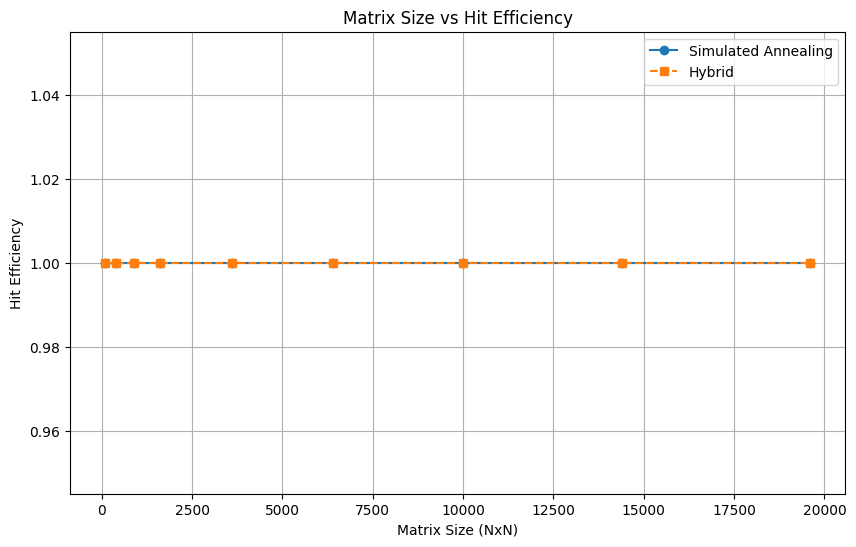

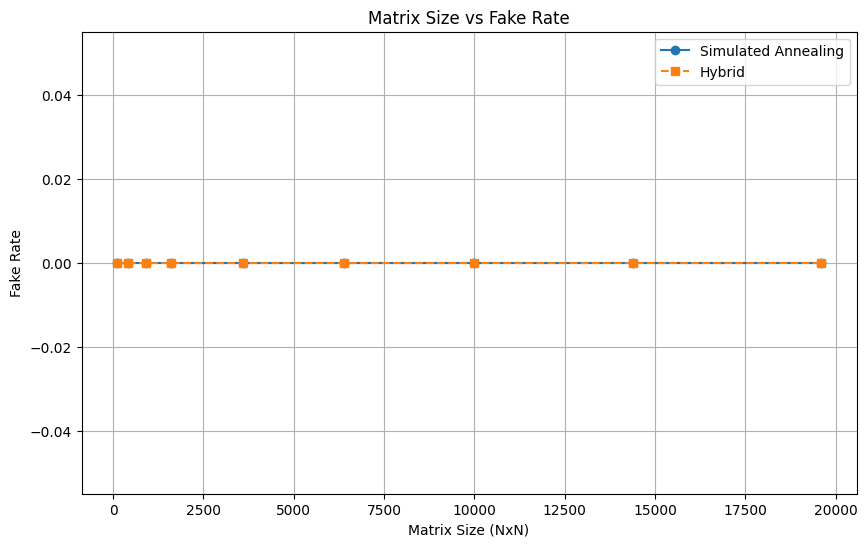

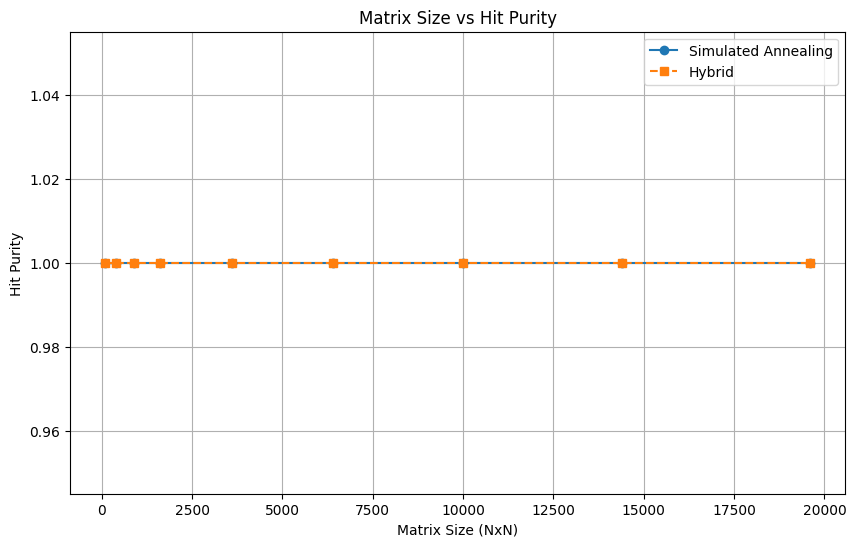

In [2]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Plot function for Hit Efficiency, Fake Rate, and Hit Purity against Matrix Size
def plot_results_by_matrix_size(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Add a Matrix Size column
    results_df['Matrix Size'] = 4 * (results_df['N_PARTICLES'] ** 2)

    # Solver name mappings
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }

    solvers = results_df['Solver'].unique()  # Get unique solvers

    # Define styles
    linestyles = ['-', '--', '-.', ':']  # Different line styles
    markers = ['o', 's', '^', 'D']       # Different markers

    # Ensure there are enough styles for all solvers
    styles = zip(linestyles * (len(solvers) // len(linestyles) + 1),
                 markers * (len(solvers) // len(markers) + 1))

    style_map = {solver: style for solver, style in zip(solvers, styles)}

    # Plot 1: Matrix Size vs Hit Efficiency
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Hit Efficiency'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Hit Efficiency")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Hit Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Matrix Size vs Fake Rate
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Fake Rates'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Fake Rate")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Fake Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Matrix Size vs Hit Purity
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Hit Purity'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Hit Purity")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Hit Purity")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate the plots
plot_results_by_matrix_size('progress.pkl')


In [3]:
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Generate LaTeX table
def generate_latex_table(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return None

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Group by solver and calculate mean metrics
    summary = results_df.groupby('Solver').agg(
        Hit_Purity=('Hit Purity', 'mean'),
        Hit_Efficiency=('Hit Efficiency', 'mean'),
        Fake_Rate=('Fake Rates', 'mean')
    ).reset_index()

    # Rename solvers for better readability
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    summary['Solver'] = summary['Solver'].map(solver_names).fillna(summary['Solver'])

    # Generate LaTeX table
    latex_table = summary.to_latex(
        index=False,
        float_format="%.2f",
        caption="QUBO Solver Results Summary",
        label="tab:qubo_results"
    )
    
    print("LaTeX Table:\n")
    print(latex_table)
    return latex_table

# Generate and display the LaTeX table
latex_code = generate_latex_table('progress.pkl')

LaTeX Table:

\begin{table}
\caption{QUBO Solver Results Summary}
\label{tab:qubo_results}
\begin{tabular}{lrrr}
\toprule
Solver & Hit_Purity & Hit_Efficiency & Fake_Rate \\
\midrule
Hybrid & 1.00 & 1.00 & 0.00 \\
Simulated Annealing & 1.00 & 1.00 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



In [4]:
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Generate LaTeX table
def generate_latex_table_detailed(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return None

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Add a Matrix Size column
    results_df['Matrix Size'] = 4 * (results_df['N_PARTICLES'] ** 2)

    # Sort by Matrix Size
    results_df = results_df.sort_values(by='Matrix Size')

    # Select relevant columns
    table_data = results_df[['Matrix Size', 'Solver', 'Hit Purity', 'Hit Efficiency', 'Fake Rates']]

    # Rename solvers for better readability
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    table_data['Solver'] = table_data['Solver'].map(solver_names).fillna(table_data['Solver'])

    # Generate LaTeX table
    latex_table = table_data.to_latex(
        index=False,
        float_format="%.2f",
        caption="QUBO Solver Results for Increasing Matrix Sizes",
        label="tab:qubo_matrix_results"
    )
    
    print("LaTeX Table:\n")
    print(latex_table)
    return latex_table

# Generate and display the LaTeX table
latex_code = generate_latex_table_detailed('progress.pkl')


LaTeX Table:

\begin{table}
\caption{QUBO Solver Results for Increasing Matrix Sizes}
\label{tab:qubo_matrix_results}
\begin{tabular}{rlrrr}
\toprule
Matrix Size & Solver & Hit Purity & Hit Efficiency & Fake Rates \\
\midrule
100 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
100 & Hybrid & 1.00 & 1.00 & 0.00 \\
400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
400 & Hybrid & 1.00 & 1.00 & 0.00 \\
900 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
900 & Hybrid & 1.00 & 1.00 & 0.00 \\
1600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
1600 & Hybrid & 1.00 & 1.00 & 0.00 \\
3600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
3600 & Hybrid & 1.00 & 1.00 & 0.00 \\
6400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
6400 & Hybrid & 1.00 & 1.00 & 0.00 \\
10000 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
10000 & Hybrid & 1.00 & 1.00 & 0.00 \\
14400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
14400 & Hybrid & 1.00 & 1.00 & 0.00 \\
19600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
19600 & Hybr

/tmp/ipykernel_1870/201737438.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data['Solver'] = table_data['Solver'].map(solver_names).fillna(table_data['Solver'])


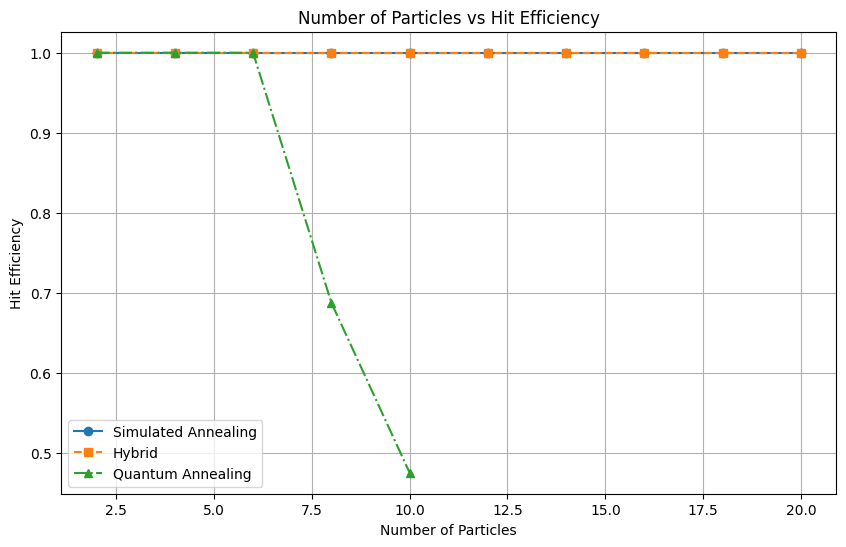

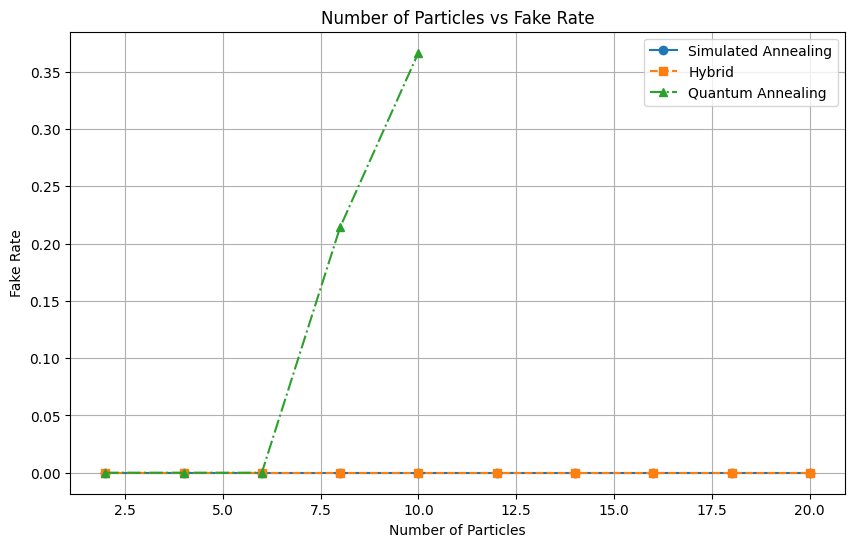

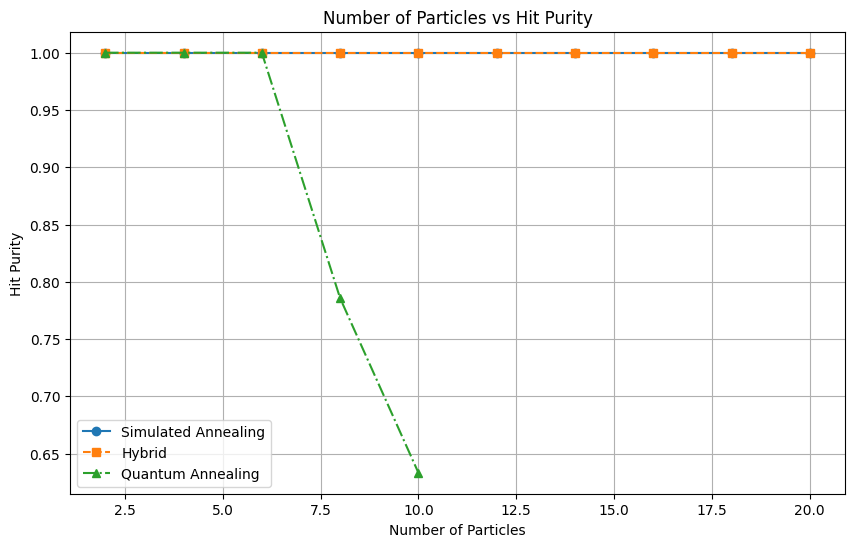

In [6]:
import matplotlib.pyplot as plt

# Plot function for Hit Efficiency, Fake Rate, and Hit Purity
def plot_results(results_df):
    # Solver name mappings
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    
    solvers = results_df['Solver'].unique()  # Get unique solvers
    
    # Define styles
    linestyles = ['-', '--', '-.', ':']  # Different line styles
    markers = ['o', 's', '^', 'D']       # Different markers
    
    # Ensure there are enough styles for all solvers
    styles = zip(linestyles * (len(solvers) // len(linestyles) + 1), 
                 markers * (len(solvers) // len(markers) + 1))
    
    style_map = {solver: style for solver, style in zip(solvers, styles)}
    
    # Plot 1: Number of Particles vs Hit Efficiency
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Efficiency'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Efficiency")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 2: Number of Particles vs Fake Rate
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Fake Rate'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Fake Rate")
    plt.xlabel("Number of Particles")
    plt.ylabel("Fake Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 3: Number of Particles vs Hit Purity
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Purity'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Purity")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Purity")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate the plots
plot_results(results_df)

In [ ]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1]
Best Energy: -4.0
Brute Force Solution: [1 0 0 1 1 0 0 1]
